In [ ]:
### UTILITIES
from keras.datasets import cifar10
from keras.utils import to_categorical
import pickle
import sys
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np

def load_dataset(batch_size, num_classes, epochs):
    (x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

    # Select a random subset of 4500 images for training
    random_indices = np.random.choice(len(x_train_full), size=50000, replace=False)
    x_train = x_train_full[random_indices]
    y_train = y_train_full[random_indices]

    # Normalize and one-hot encode the labels
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    # Randomly select 500 images for validation
    random_indices = np.random.choice(len(x_test), size=10000, replace=False)
    x_val = x_test[random_indices]
    y_val = y_test[random_indices]

    dataset = {
        'batch_size': batch_size,
        'num_classes': num_classes,
        'epochs': epochs,
        'x_train': x_train,
        'y_train': y_train,
        'x_val': x_val,
        'y_val': y_val,
        'x_test': x_test,  
        'y_test': y_test
    }

    return dataset


def save_network(network):
    #object_file = open(network.name + '.obj', 'wb')
    #pickle.dump(network, object_file)
    #tf.keras.models.save_model(network, network.name)

    model_path = network.name + '_model.h5'
    tf.keras.models.save_model(network.model, model_path)

    # Save the rest of the network information
    network_info = {
        'name': network.name,
        'block_list': network.block_list,
        'fitness': network.fitness
    }
    network_info_path = network.name + '_info.pkl'
    with open(network_info_path, 'wb') as info_file:
        pickle.dump(network_info, info_file)


def load_network(name):
    model_path = name + '_model.h5'
    loaded_model = tf.keras.models.load_model(model_path)

    # Load the network information
    info_path = name + '_info.pkl'
    with open(info_path, 'rb') as info_file:
        network_info = pickle.load(info_file)

    # Create a new Network instance
    loaded_network = Network(0)  # Update with appropriate 'it' value

    # Set the attributes of the loaded network
    loaded_network.name = network_info['name']
    loaded_network.block_list = network_info['block_list']
    loaded_network.fitness = network_info['fitness']
    loaded_network.model = loaded_model

    return loaded_network



def order_indexes(self):
    i = 0
    for block in self.block_list:
        block.index = i
        i += 1


def plot_training(history):                                           # plot diagnostic learning curves
    plt.figure(figsize=[8, 6])  # accuracy curves
    plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
    plt.plot(history.history['val_accuracy'], 'b', linewidth=3.0)  # <-- Change 'val_acc' to 'val_accuracy'
    plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.title('Accuracy Curves', fontsize=16)

    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_acc_plot.png')
    plt.close()



def plot_statistics(stats):
    plt.figure(figsize=[8, 6])											# fitness curves
    plt.plot([s[0] for s in stats], 'r', linewidth=3.0)
    plt.plot([stats[0][0]] * len(stats), 'b', linewidth=3.0)
    plt.legend(['BestFitness', 'InitialFitness'], fontsize=18)
    plt.xlabel('Generations', fontsize=16)
    plt.ylabel('FitnessValue', fontsize=16)
    plt.title('Fitness Curve', fontsize=16)
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_fitness_plot.png')

    plt.figure(figsize=[8, 6])											# parameters curves
    plt.plot([s[1] for s in stats], 'r', linewidth=3.0)
    plt.plot([stats[0][1]] * len(stats), 'b', linewidth=3.0)
    plt.legend(['BestParamsNum', 'InitialParamsNum'], fontsize=18)
    plt.xlabel('Generations', fontsize=16)
    plt.ylabel('ParamsNum', fontsize=16)
    plt.title('Parameters Curve', fontsize=16)
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_params_plot.png')
    plt.close()


In [ ]:
# INOUT
import os
def compute_parent(dataset):
    if os.path.isfile('parent_0.h5'):
        daddy = load_network('parent_0')
        model = tf.keras.models.load_model('parent_0.h5')
        print("Loading parent_0")
        print("SUMMARY OF", daddy.name)
        print(model.summary())
        print("FITNESS:", daddy.fitness)
        return daddy

    daddy = Network(0)
    
    
    #INI BLOCK
    layerList1 = [
        Convolutional(filters=32, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:]),
        Convolutional(filters=64, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:])
    ]
    layerList2 = [
        Pooling(pool_size=(2, 2), stride_size=(2, 2), padding='same')
    ]
    daddy.block_list.append(Block(0, 0, layerList1, layerList2))
    
    #MIDDLE BLOCK 1
    layerList1 = [
        Convolutional(filters=64, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:]),
    ]
    layerList2 = [
        Pooling(pool_size=(2, 2), stride_size=(2, 2), padding='same')
    ]
    daddy.block_list.append(Block(1, 1, layerList1, layerList2))

     #MIDDLE BLOCK 2
    layerList1 = [
        Convolutional(filters=128, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:]),
        Convolutional(filters=128, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:])
    ]
    layerList2 = [
        Pooling(pool_size=(2, 2), stride_size=(2, 2), padding='same')
    ]
    daddy.block_list.append(Block(1, 2, layerList1, layerList2))

    
    #MIDDLE BLOCK 3
    layerList1 = [
        Convolutional(filters=256, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:]),
        Convolutional(filters=256, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:])
    ]
    layerList2 = [
        Pooling(pool_size=(2, 2), stride_size=(2, 2), padding='same')
    ]
    daddy.block_list.append(Block(1, 3, layerList1, layerList2))
    
    
    
    #MIDDLE BLOCK 4
    layerList1 = [
        Convolutional(filters=512, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:]),
        Convolutional(filters=512, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:])
    ]
    layerList2 = [
        Pooling(pool_size=(2, 2), stride_size=(2, 2), padding='same')
    ]
    daddy.block_list.append(Block(1, 4, layerList1, layerList2))
    
    
    
    #FULLY CONNECTED LAYER
    layerList1 = [
        FlattenLayer(),
        FullyConnected(units=128, num_classes=dataset['num_classes'])
    ]
    layerList2 = []
    daddy.block_list.append(Block(2, 5, layerList1, layerList2))
    
    

    model = daddy.build_model()
    print("Type of model_final:", type(model))
    daddy.train_and_evaluate(model, dataset)
    return daddy

In [ ]:
# NETWORK
import tensorflow as tf
import os
import pickle
from keras.callbacks import Callback
from keras.models import Sequential
from random import randint, choice
from copy import deepcopy


class Network:
    __slots__ = ('name', 'block_list', 'fitness', 'model')

    def __init__(self, it):
        self.name = 'parent_' + str(it) if it == 0 else 'net_' + str(it)
        self.block_list = []
        self.fitness = None
        self.model = None

    """def build_model(self):
        model = Sequential()                                # create model
        for block in self.block_list:
            for layer in block.get_layers():                # build model
                try:
                    layer.build_layer(model)
                except:
                    print("\nINDIVIDUAL ABORTED, CREATING A NEW ONE\n")
                    return -1
        return model"""
    def build_model(self):
        model = Sequential()              
        print("The block is:")
        print(self.block_list)                 # create model
        for block in self.block_list:
            #print("Building block type:", block.type)
            #print("TOTAL :::")
            #print(block.get_layer_name())
            for layer in block.get_layers():                # build model
                #print("Adding layer:", layer.name)
                try:
                    layer.build_layer(model)
                    print("Layer added successfully.")
                except Exception as e:
                    print("Error occurred while adding layer:", e)
                    print("Returning None.")
                    return -1
        print("Model successfully built.")
        return model

    def train_and_evaluate(self, model, dataset):
        print("Training", self.name)
        model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
        try:
            history = model.fit(dataset['x_train'],
                                dataset['y_train'],
                                batch_size=dataset['batch_size'],
                                epochs=dataset['epochs'],
                                validation_data=(dataset['x_val'], dataset['y_val']),
                                shuffle=True)
        except Exception as e:
            print("An error occurred during model training:", e)
            return -1
            # You can choose to handle the error in a specific way here, like logging it or taking corrective actions.


        # Extract metrics from the training history
        training_loss = history.history['loss'][-1]
        training_accuracy = history.history['accuracy'][-1]
        validation_loss = history.history['val_loss'][-1]
        validation_accuracy = history.history['val_accuracy'][-1]

        # Additional metrics (you can customize this based on your needs)
        classification_error_rate = 1.0 - validation_accuracy

        self.model = model  # Save the model
        self.fitness = validation_loss  # Use validation loss as fitness

        # Print metrics
        print("SUMMARY OF", self.name)
        print("Training Loss:", training_loss)
        print("Training Accuracy:", training_accuracy)
        print("Validation Loss:", validation_loss)
        print("Validation Accuracy:", validation_accuracy)
        print("Classification Error Rate:", classification_error_rate)

        tf.keras.models.save_model(model, self.name + '.h5')         # save model
        #model.save(self.name + '.h5')                       # save model
        save_network(self)                                  # save topology, model and fitness

    def asexual_reproduction(self, it, dataset):

        # if the individual already exists, just load it
        if os.path.isfile('net_' + str(it) + '.h5'):
            print("\n-------------------------------------")
            print("Loading individual net_" + str(it))
            print("--------------------------------------\n")
            individual = load_network('net_' + str(it))
            model = tf.keras.models.load_model(individual.name + '.h5')
            print("SUMMARY OF", individual.name)
            print(model.summary())
            print("FITNESS: ", individual.fitness)
            return individual

        # otherwise, create the individual by mutating the parent
        individual = Network(it)

        print("\n-------------------------------------")
        print("\nCreating individual", individual.name)
        print("--------------------------------------\n")

        individual.block_list = deepcopy(self.block_list)           # copy the layer list from parent

        print("----->Strong Mutation")
        individual.block_mutation(dataset)                          # mutate a block
        individual.layer_mutation(dataset)                          # mutate a layer
        individual.parameters_mutation()                            # mutate some parameters

        model = individual.build_model()
        
        if model == -1:
            return self.asexual_reproduction(it, dataset)
        
        if(individual.train_and_evaluate(model, dataset)==-1):
            return self.asexual_reproduction(it, dataset)
        else:
            return individual
            

    def block_mutation(self, dataset):
        try:
            print("Block Mutation")

            print([(block.index, block.type) for block in self.block_list])

            # block list containing all the blocks with type = 1
            bl = [block.index for block in self.block_list if block.type == 1]

            if len(bl) == 0:
                print("Creating a new block with two Convolutional layers and a Pooling layer")
                self.block_list[1].index = 2
                layerList1 = [
                    Convolutional(filters=pow(2, randint(5, 8)),
                                  filter_size=(3, 3),
                                  stride_size=(1, 1),
                                  padding='same',
                                  input_shape=dataset['x_train'].shape[1:]),
                    Convolutional(filters=pow(2, randint(5, 8)),
                                  filter_size=(3, 3),
                                  stride_size=(1, 1),
                                  padding='same',
                                  input_shape=dataset['x_train'].shape[1:])
                ]
                layerList2 = [
                    Pooling(pool_size=(2, 2),
                            stride_size=(2, 2),
                            padding='same')
                ]
                b = Block(1, 1, layerList1, layerList2)
                self.block_list.insert(1, b)
                return

            block_idx = randint(1, max(bl))         # pick a random block among all the blocks with type = 1
            block_type_idx = randint(0, 1)          # 1 -> Conv2D; 0 -> Pooling or Dropout
            mutation_type = randint(0, 1)           # 1 -> remove; 0 -> add

            # list of layers of the selected block
            layerList = self.block_list[block_idx].layerList1 if block_type_idx else self.block_list[block_idx].layerList2
            length = len(layerList)

            if mutation_type:                                       # remove
                if length == 1:
                    del self.block_list[block_idx]
                elif block_type_idx:
                    pos = randint(0, length - 1)
                    print("Removing a Conv2D layer at", pos)
                    del layerList[pos]
                else:
                    pos = randint(0, length - 1)
                    print("Removing a Pooling/Dropout layer at", pos)
                    del layerList[pos]
            else:                                                   # add
                if block_type_idx:
                    print("Inserting a Convolutional layer")
                    layer = Convolutional(filters=pow(2, randint(5, 8)),
                                          filter_size=(3, 3),
                                          stride_size=(1, 1),
                                          padding='same',
                                          input_shape=dataset['x_train'].shape[1:])
                    layerList.insert(randint(0, length - 1), layer)
                else:
                    if randint(0, 1):                               # 1 -> Pooling; 0 -> Dropout
                        print("Inserting a Pooling layer")
                        layer = Pooling(pool_size=(2, 2),
                                        stride_size=(2, 2),
                                        padding='same')
                        layerList.insert(randint(0, length - 1), layer)
                    else:
                        print("Inserting a Dropout layer")
                        rate = choice([0.15, 0.25, 0.35, 0.50])
                        layer = Dropout(rate=rate)
                        layerList.insert(randint(0, length - 1), layer)
        except Exception as e:
            print(f"An error occurred during block mutation: {e}")
            return None

                    
                    
                    
                    
                    

    """def layer_mutation(self, dataset):
        print("Layer Mutation")

        # pick a random block among all the blocks with type = 1
        bl = [block.index for block in self.block_list if block.type == 1]

        if len(bl) == 0:
            return

        block_idx = randint(1, max(bl))
        block_type_idx = randint(0, 1)      # 1 -> Conv2D; 0 -> Pooling or Dropout

        # list of layers of the selected block
        layerList = self.block_list[block_idx].layerList1 if block_type_idx else self.block_list[block_idx].layerList2

        if len(layerList) == 0:
            if block_type_idx:
                layer = Convolutional(filters=pow(2, randint(5, 8)),
                                      filter_size=(3, 3),
                                      stride_size=(1, 1),
                                      padding='same',
                                      input_shape=dataset['x_train'].shape[1:])
                self.block_list[block_idx].layerList1.append(layer)
                return
            else:
                layer = Pooling(pool_size=(2, 2),
                                stride_size=(2, 2),
                                padding='same')
                self.block_list[block_idx].layerList2.append(layer)

        idx = randint(0, len(layerList) - 1)
        layer = layerList[idx]

        if layer.name == 'Conv2D':
            print("Splitting Conv2D layer at index", idx)
            layer.filters = int(layer.filters * 0.5)
            layerList.insert(idx, deepcopy(layer))
        elif layer.name == 'MaxPooling2D' or layer.name == 'AveragePooling2D':
            print("Changing Pooling layer at index", idx, "with Conv2D layer")
            del layerList[idx]
            conv_layer = Convolutional(filters=pow(2, randint(5, 8)),
                                       filter_size=(3, 3),
                                       stride_size=(2, 2),
                                       padding=layer.padding,
                                       input_shape=dataset['x_train'].shape[1:])
            layerList.insert(idx, conv_layer)"""
    
    def layer_mutation(self, dataset):
        print("Layer Mutation")

        # Determine the maximum number of layers that can be added or removed
        max_layers_to_add = 16 - sum(len(block.layerList1) + len(block.layerList2) for block in self.block_list)
        max_layers_to_remove = sum(len(block.layerList1) + len(block.layerList2) - 1 for block in self.block_list)

        if max_layers_to_add == 0 and max_layers_to_remove == 0:
            return

        # Pick a random block among all the blocks with type = 1
        bl = [block.index for block in self.block_list if block.type == 1]

        if len(bl) == 0:
            return

        block_idx = randint(1, max(bl))
        block_type_idx = randint(0, 1)      # 1 -> Conv2D; 0 -> Pooling or Dropout

        # List of layers of the selected block
        layerList = self.block_list[block_idx].layerList1 if block_type_idx else self.block_list[block_idx].layerList2

        if len(layerList) == 0:
            if block_type_idx:
                layer = Convolutional(filters=pow(2, randint(5, 8)),
                                      filter_size=(3, 3),
                                      stride_size=(1, 1),
                                      padding='same',
                                      input_shape=dataset['x_train'].shape[1:])
                self.block_list[block_idx].layerList1.append(layer)
            else:
                layer = Pooling(pool_size=(2, 2),
                                stride_size=(2, 2),
                                padding='same')
                self.block_list[block_idx].layerList2.append(layer)
        else:
            # Randomly choose whether to add or remove a layer
            add_layer = bool(randint(0, 1))

            if add_layer and max_layers_to_add > 0:
                # Add a layer
                layer = self.create_random_layer(dataset)
                layerList.insert(randint(0, len(layerList)), layer)
            elif not add_layer and max_layers_to_remove > 0:
                # Remove a layer
                idx = randint(0, len(layerList) - 1)
                del layerList[idx]

        # Ensure the total number of layers in the block doesn't exceed 16
        if len(self.block_list[block_idx].layerList1) + len(self.block_list[block_idx].layerList2) > 16:
            # Remove a random layer to maintain the total count of 16 layers
            block_layerList = self.block_list[block_idx].layerList1 if block_type_idx else self.block_list[block_idx].layerList2
            del block_layerList[randint(0, len(block_layerList) - 1)]

    def create_random_layer(self, dataset):
        # Create a random layer (Conv2D or Pooling)
        if randint(0, 1):
            # Conv2D layer
            return Convolutional(filters=pow(2, randint(5, 8)),
                                 filter_size=(3, 3),
                                 stride_size=(1, 1),
                                 padding='same',
                                 input_shape=dataset['x_train'].shape[1:])
        else:
            # Pooling layer
            return Pooling(pool_size=(2, 2),
                           stride_size=(2, 2),
                           padding='same')

            
            
            
            
            
            
            
            

    def parameters_mutation(self):
        print("Parameters Mutation")
        for block in self.block_list:
            for layer in block.get_layers():
                if randint(0, 1):
                    layer.mutate_parameters()

    def save_network_info(self, info_filename):
        network_info = {
            'name': self.name,
            'block_list': self.block_list,
            'fitness': self.fitness
        }

        with open(info_filename, 'wb') as info_file:
            pickle.dump(network_info, info_file)

    def load_network_info(self, info_filename):
        with open(info_filename, 'rb') as info_file:
            network_info = pickle.load(info_file)

        self.name = network_info['name']
        self.block_list = network_info['block_list']
        self.fitness = network_info['fitness']

    def save_model(self, model_filename):
        self.model.save(model_filename)

    def load_model(self, model_filename):
        self.model = tf.keras.models.load_model(model_filename)

    def save_network(self, network_info_filename, model_filename):
        # Save non-model attributes
        self.save_network_info(network_info_filename)

        # Save the model separately
        self.save_model(model_filename)

    def load_network(self, network_info_filename, model_filename):
        # Load non-model attributes
        self.load_network_info(network_info_filename)

        # Load the model separately
        self.load_model(model_filename)


In [ ]:
# TOPOLOGY

import keras.layers
from random import randint


class Block:
	__slots__ = ('type', 'index', 'layerList1', 'layerList2')

	def __init__(self, type, index, layerList1, layerList2):
		self.type = type										# 0 -> initial layer; 1 -> mid layers; 2 -> final layer
		self.index = index										# block index among all the blocks
		self.layerList1 = layerList1							# Convolutional layers
		self.layerList2 = layerList2							# Pooling and Dropout layers

	def get_layers(self):
		return self.layerList1 + self.layerList2

	def get_size(self):
		return len(self.get_layers())


class Convolutional:
	# __slots__ = ('name', 'filters', 'padding', 'filter_size', 'stride_size', 'input_shape')

	def __init__(self, filters, padding, filter_size, stride_size, input_shape):
		self.name = 'Conv2D'
		self.filters = filters
		self.padding = padding
		self.filter_size = filter_size
		self.stride_size = stride_size
		self.input_shape = input_shape

	def build_layer(self, model):
		try:
			model.add(keras.layers.Conv2D(filters=self.filters,
											kernel_size=self.filter_size,
											strides=self.stride_size,
											padding=self.padding,
											activation='relu',
											kernel_initializer='he_uniform',
											input_shape=self.input_shape))
		except ValueError as e:
			print("Error occurred while adding layer:", e)
			print("Skipping current architecture.")
			return  # Skip adding this layer
	def mutate_parameters(self):
		mutation = randint(0, 2)  # Adjusted the number of mutations
		print("Mutating", self.name, "layer:")
		if mutation == 0 and self.filters >= 64:  # Adjusted the filter reduction threshold
			print("-->changed self.filters from ", self.filters, " ", end="")
			self.filters = int(self.filters / 2)
			print("to ", self.filters)
		elif mutation == 1 and self.filters <= 256:  # Adjusted the filter increase threshold
			print("-->changed self.filters from ", self.filters, " ", end="")
			self.filters *= 2
			print("to ", self.filters)
		elif mutation == 2:
			if self.padding == 'valid':
				print("-->changed self.padding from ", self.padding, " ", end="")
				self.padding = 'same'
				print("to ", self.padding)
			else:
				print("-->changed self.padding from ", self.padding, " ", end="")
				self.padding = 'valid'
				print("to ", self.padding)

        

        


	"""def mutate_parameters(self):
		mutation = randint(0, 4)
		print("Mutating", self.name, "layer:")
		if mutation == 0 and self.filters >= 32:
			print("-->changed self.filters from ", self.filters, " ", end="")
			self.filters = int(self.filters / 2)
			print("to ", self.filters)
		elif mutation == 1 and self.filters >= 32:
			print("-->changed self.filters from ", self.filters, " ", end="")
			self.filters = int(self.filters / 2)
			print("to ", self.filters)
		elif mutation == 2 and self.filters <= 512:
			print("-->changed self.filters from ", self.filters, " ", end="")
			self.filters *= 2
			print("to ", self.filters)
		elif mutation == 3 and self.filters <= 512:
			print("-->changed self.filters from ", self.filters, " ", end="")
			self.filters *= 2
			print("to ", self.filters)
		elif mutation == 4:
			if self.padding == 'valid':
				print("-->changed self.padding from ", self.padding, " ", end="")
				self.padding = 'same'
				print("to ", self.padding)
			else:
				print("-->changed self.padding from ", self.padding, " ", end="")
				self.padding = 'valid'
				print("to ", self.padding)
"""
    

'''
elif mutation is 4:
	print("changed self.stride_size from ", self.stride_size, " ", end="")
	self.stride_size = (self.stride_size[0] + 1, self.stride_size[1] + 1)
	print("to ", self.stride_size, " and ", end="")
	print("changed self.stride_size from ", self.stride_size, " ", end="")
	self.stride_size = (self.stride_size[0] + 1, self.stride_size[1] + 1)
	print("to ", self.stride_size)
'''


class Pooling:
	__slots__ = ('name', 'pool_size', 'stride_size', 'padding')

	def __init__(self, pool_size, stride_size, padding):
		self.name = 'MaxPooling2D'
		self.pool_size = pool_size
		self.stride_size = stride_size
		self.padding = padding

	def build_layer(self, model):
		if self.name == 'MaxPooling2D':
			model.add(keras.layers.MaxPooling2D(self.pool_size, self.stride_size, self.padding))
		elif self.name == 'AveragePooling2D':
			model.add(keras.layers.AveragePooling2D(self.pool_size, self.stride_size, self.padding))

	def mutate_parameters(self):
		print("Mutating", self.name, "layer:")
		mutation = randint(0, 1)
		if mutation == 0:
			if self.padding == 'valid':
				print("-->changed self.padding from ", self.padding, " ", end="")
				self.padding = 'same'
				print("to ", self.padding)
			else:
				print("-->changed self.padding from ", self.padding, " ", end="")
				self.padding = 'valid'
				print("to ", self.padding)
		elif mutation == 1:
			if self.name == 'MaxPooling2D':
				print("-->changed self.name from ", self.name, " ", end="")
				self.name = 'AveragePooling2D'
				print("to ", self.name)
			else:
				print("-->changed self.name from ", self.name, " ", end="")
				self.name = 'MaxPooling2D'
				print("to ", self.name)


'''
if mutation is 0:
	print("changed self.stride_size from ", self.stride_size, " ", end="")
	self.stride_size = (self.stride_size[0] + 1, self.stride_size[1] + 1)
	print("to ", self.stride_size)
'''


class FullyConnected:
	__slots__ = ('name', 'units', 'num_classes')

	def __init__(self, units, num_classes):
		self.name = "FullyConnected"
		self.units = units
		self.num_classes = num_classes

	def build_layer(self, model):
		model.add(keras.layers.Flatten())
		model.add(keras.layers.Dense(self.units, activation='relu', kernel_initializer='he_uniform'))
		model.add(keras.layers.Dense(self.num_classes, activation='softmax'))

	def mutate_parameters(self):
		print("Mutating", self.name, "layer:")
		mutation = randint(0, 2)
		if mutation == 0:
			print("-->changed self.units from ", self.units, " ", end="")
			self.units *= 2
			print("to ", self.units)
		elif mutation == 1:
			print("-->changed self.units from ", self.units, " ", end="")
			self.units *= 2
			print("to ", self.units)
		elif mutation == 2:
			print("-->changed self.units from ", self.units, " ", end="")
			self.units /= 2
			print("to ", self.units)


'''
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(self.num_classes, activation='softmax'))
'''


class Dropout:
	__slots__ = ('name', 'rate')

	def __init__(self, rate):
		self.name = "Dropout"
		self.rate = rate

	def build_layer(self, model):
		model.add(keras.layers.Dropout(self.rate))

	def mutate_parameters(self):
		print("Mutating", self.name, "layer:")
		mutation = randint(0, 3)
		if mutation == 0 and self.rate <= 0.85:
			print("-->changed self.rate from ", self.rate, " ", end="")
			self.rate = self.rate + 0.10
			print("to ", self.rate)
		elif mutation == 1 and self.rate <= 0.90:
			print("-->changed self.rate from ", self.rate, " ", end="")
			self.rate = self.rate + 0.05
			print("to ", self.rate)
		elif mutation == 2 and self.rate >= 0.15:
			print("-->changed self.rate from ", self.rate, " ", end="")
			self.rate = self.rate - 0.10
			print("to ", self.rate)
		elif mutation == 3 and self.rate >= 0.10:
			print("-->changed self.rate from ", self.rate, " ", end="")
			self.rate = self.rate - 0.05
			print("to ", self.rate)

class FlattenLayer:
    def __init__(self):
        self.name = 'Flatten'

    def build_layer(self, model):
        model.add(keras.layers.Flatten())

    def mutate_parameters(self):
        # The Flatten layer does not have any parameters to mutate
        pass


In [ ]:
"""# MAIN

import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import os
from copy import deepcopy
from random import sample
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)      # suppress messages from Tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


def initialize_population(population_size, dataset):
    print("----->Initializing Population")
    daddy = compute_parent(dataset)                                 # load parent from input
    population = [daddy]
    for it in range(1, population_size):
        population.append(daddy.asexual_reproduction(it, dataset))

    # sort population on ascending order based on fitness
    return sorted(population, key=lambda cnn: cnn.fitness)


def selection(k, population, num_population):
    if k == 0:                                              # elitism selection
        print("----->Elitism selection")
        return population[0], population[1]
    elif k == 1:                                            # tournament selection
        print("----->Tournament selection")
        i = randint(0, num_population - 1)
        j = i
        while j < num_population - 1:
            j += 1
            if randint(1, 100) <= 50:
                return population[i], population[j]
        return population[i], population[0]
    else:                                                   # proportionate selection
        print("----->Proportionate selection")
        cum_sum = 0
        for i in range(num_population):
            cum_sum += population[i].fitness
        perc_range = []
        for i in range(num_population):
            count = 100 - int(100 * population[i].fitness / cum_sum)
            for j in range(count):
                perc_range.append(i)
        i, j = sample(range(1, len(perc_range)), 2)
        while i == j:
            i, j = sample(range(1, len(perc_range)), 2)
        return population[perc_range[i]], population[perc_range[j]]


def crossover(parent1, parent2, it):
    print("----->Crossover")
    child = Network(it)

    first, second = None, None
    if randint(0, 1):
        first = parent1
        second = parent2
    else:
        first = parent2
        second = parent1

    child.block_list = deepcopy(first.block_list[:randint(1, len(first.block_list) - 1)]) \
                       + deepcopy(second.block_list[randint(1, len(second.block_list) - 1):])

    order_indexes(child)                            # order the indexes of the blocks

    return child


def genetic_algorithm(num_population, num_generation, num_offspring, dataset, early_stopping_generations=3):
    print("Genetic Algorithm")

    population = initialize_population(num_population, dataset)

    print("\n-------------------------------------")
    print("Initial Population:")
    for cnn in population:
        print(cnn.name, ': ', cnn.fitness)
    print("--------------------------------------\n")

    # for printing statistics about fitness and the number of parameters of the best individual
    stats = [(population[0].fitness, population[0].model.count_params())]

    # Initialize a variable to keep track of consecutive generations with the same best fitness
    consecutive_same_fitness = 0

    for gen in range(1, num_generation + 1):
        '''
            k is the selection parameter:
                k = 0 -> elitism selection
                k = 1 -> tournament selection
                k = 2 -> proportionate selection
        '''
        k = randint(0, 2)

        print("\n------------------------------------")
        print("Generation -----------------------------------------------------------------------------------", gen)
        print("-------------------------------------")

        for c in range(num_offspring):

            print("\nCreating Child", c)

            parent1, parent2 = selection(k, population, num_population)                 # selection
            print("Selected", parent1.name, "and", parent2.name, "for reproduction")

            child = crossover(parent1, parent2, c + num_population)                     # crossover
            print("Child has been created")

            print("----->Soft Mutation")
            child.layer_mutation(dataset)                                               # mutation
            child.parameters_mutation()
            print("Child has been mutated")
            model = child.build_model()  
            # evaluation
            if model==-1:
                pass
            else:
                if(child.train_and_evaluate(model,dataset)==-1):
                    model=-1  
            #if(child.train_and_evaluate(model,dataset)==-1):
                    #model=-1  # evaluation

            while model == -1:
                child = crossover(parent1, parent2, c + num_population)
                child.block_mutation(dataset)
                child.layer_mutation(dataset)
                child.parameters_mutation()
                model = child.build_model()
                if(model==-1):
                    pass
                else:
                    if(child.train_and_evaluate(model,dataset)==-1):
                        model=-1

            #child.train_and_evaluate(model, dataset)

            if child.fitness < population[-1].fitness:                                  # evolve population
                print("----->Evolution: Child", child.name, "with fitness", child.fitness, "replaces parent ", end="")
                print(population[-1].name, "with fitness", population[-1].fitness)
                name = population[-1].name

                child.save_network("child_model_info.pkl", "child_model.h5")
                population[-1].load_network("child_model_info.pkl", "child_model.h5")

                population[-1].name = name
                population = sorted(population, key=lambda net: net.fitness)
            else:
                print("----->Evolution: Child", child.name, "with fitness", child.fitness, "is discarded")
        
        if gen >= 3 and all(population[i].fitness == population[i + 1].fitness for i in range(-3, -1)):
            consecutive_same_fitness += 1
            print(f"Consecutive generations with the same best fitness: {consecutive_same_fitness}")
        if consecutive_same_fitness >= 3:
            print("Stopping the algorithm as the best fitness has remained the same for the last 3 generations.")
            break
    else:
        consecutive_same_fitness = 0
        
       #Check if the best fitness has remained the same for the last early_stopping_generations generations
        if all(population[i].fitness == population[i + 1].fitness for i in range(-early_stopping_generations, -1)):
            consecutive_same_fitness += 1
            print(f"Consecutive generations with the same best fitness: {consecutive_same_fitness}")
            if consecutive_same_fitness == early_stopping_generations:
                print(f"Stopping the algorithm as the best fitness has remained the same for {early_stopping_generations} generations.")
        else:
            consecutive_same_fitness = 0
        stats.append((population[0].fitness, population[0].model.count_params()))

    print("\n\n-------------------------------------")
    print("Final Population")
    print("-------------------------------------\n")
    for cnn in population:
        print(cnn.name, ': ', cnn.fitness)

    print("\n-------------------------------------")
    print("Stats")
    for i in range(len(stats)):
        print("Best individual at generation", i + 1, "has fitness", stats[i][0], "and parameters", stats[i][1])
    print("-------------------------------------\n")

    # plot the fitness and the number of parameters of the best individual at each iteration
    plot_statistics(stats)

    return population[0]



def main():    
        #with strategy.scope():
        #from tensorflow.python.client import device_lib
        #print(device_lib.list_local_devices())
        #batch_size = 8
        #batch_size = batch_size * strategy.num_replicas_in_sync
        batch_size = 32                       # the number of training examples in one forward/backward pass
        num_classes = 10                        # number of cifar-10 dataset classes
        epochs =20              # number of forward and backward passes of all the training examples

        '''
            dataset contains the hyper parameters for loading data and the dataset:
                dataset = {
                    'batch_size': batch_size,
                    'num_classes': num_classes,
                    'epochs': epochs,
                    'x_train': x_train,
                    'x_test': x_test,
                    'y_train': y_train,
                    'y_test': y_test
                }
        '''
        dataset = load_dataset(batch_size, num_classes, epochs)

        num_population = 10
        num_generation = 20
        num_offspring = 4

        # plot the best model obtained
        optCNN = genetic_algorithm(num_population, num_generation, num_offspring, dataset)

        # plot the training and validation loss and accuracy
        num_epoch = 20
        model = optCNN.build_model()
        model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(dataset['x_train'],
                            dataset['y_train'],
                            batch_size=dataset['batch_size'],
                            epochs=num_epoch,
                            validation_data=(dataset['x_test'], dataset['y_test']),
                            shuffle=True)
        optCNN.model = model                                        # model
        optCNN.fitness = history.history['val_loss'][-1]            # fitness

        print("\n\n-------------------------------------")
        print("The Final CNN has been evolved successfully in the individual", optCNN.name)
        print("-------------------------------------\n")
        daddy = load_network('parent_0')
        model = tf.keras.models.load_model('parent_0.h5')
        print("\n\n-------------------------------------")
        print("Summary of initial CNN")
        print(model.summary())
        print("Fitness of initial CNN:", daddy.fitness)

        print("\n\n-------------------------------------")
        print("Summary of evolved individual")
        print(optCNN.model.summary())
        print("Fitness of the evolved individual:", optCNN.fitness)
        print("-------------------------------------\n")

        plot_training(history)


if __name__ == '__main__':
    main()


In [ ]:
"""## To remove a folder
# Clear output folder
import os

def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)
os.rmdir(folder_path)""""""

In [69]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

# Set the paths to the datasets
image_dir = '/kaggle/input/cifar100-20-classes-images/final'
csv_file = '/kaggle/input/d/devasundersj/cifar100-20classes-mixing-new-latest/cifar100_20classes_mixing_new_latest.csv'

In [70]:
# Load the image and text data
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
data = pd.read_csv(csv_file)

In [71]:
data

,caption,class,filename
0,An apple on a wooden table.,0,class_0_image_0
1,A juicy red apple in a fruit basket.,0,class_0_image_1
2,An apple with a bite taken out of it.,0,class_0_image_2
3,A shiny green apple on a kitchen counter.,0,class_0_image_3
4,An apple orchard with trees full of ripe fruit.,0,class_0_image_4
...,...,...,...
11979,A field of tulips in different colors.,92,class_92_image_594
11980,A colorful bouquet of mixed flowers.,92,class_92_image_595
11981,A single blue flower in a sea of green leaves.,92,class_92_image_596
11982,A garden bed full of blooming flowers.,92,class_92_image_597


In [72]:
# Load the LSTM and CNN models
lstm_model = tf.keras.models.load_model('/kaggle/input/cifar-100-randomclass-lstmmodel/net_1_lstm_cifar200_20_random.h5')
cnn_model = tf.keras.models.load_model('/kaggle/input/cnn-models-fashion-cifar100/cifar_100_20classes_net13.h5')

In [73]:
import os
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from PIL import Image

def load_image(image_path, image_shape):
    image = Image.open(image_path)
    image = image.resize((image_shape[1], image_shape[0]))  # Resize to match the required shape
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

In [74]:
# Usage:
image_folder = '/kaggle/input/cifar100-20-classes-images/final'
captions_df = pd.read_csv('/kaggle/input/d/devasundersj/cifar100-20classes-mixing-new-latest/cifar100_20classes_mixing_new_latest.csv')  # Assuming captions are stored in a CSV file
num_classes = 20  # Number of classes/categories
image_shape = (32, 32, 3)  # Define the shape of the images

In [75]:
# Step 1: Load image data from the folder
images = []
image_filenames = []
for filename in os.listdir(image_folder):
    if filename.endswith(".jpg"):  # Assuming images are in png format
            image_path = os.path.join(image_folder, filename)
            image = load_image(image_path, image_shape)
            images.append(image)
            image_filenames.append(os.path.splitext(filename)[0])  # Remove file extension



In [76]:
image_filenames[0]

'class_84_image_540'

In [77]:
captions_df['caption']

0                              An apple on a wooden table.
1                     A juicy red apple in a fruit basket.
2                    An apple with a bite taken out of it.
3                A shiny green apple on a kitchen counter.
4          An apple orchard with trees full of ripe fruit.
                               ...                        
11979               A field of tulips in different colors.
11980                 A colorful bouquet of mixed flowers.
11981       A single blue flower in a sea of green leaves.
11982               A garden bed full of blooming flowers.
11983    A bunch of daffodils announcing the arrival of...
Name: caption, Length: 11984, dtype: object

In [78]:
filename

'class_24_image_137.jpg'

In [79]:

class_index = int(filename.split('_')[1])
class_index

24

In [80]:
image_index = int(filename.split('_')[3].split('.')[0])
image_index

137

In [81]:
image_filenames[0]

'class_84_image_540'

In [82]:
len(image_filenames)

11984

In [83]:
image_captions = []
image_classes = []
for filename in image_filenames:
    #print(filename)
    class_index = int(filename.split('_')[1])
    #print(class_index)
    image_index = int(filename.split('_')[3].split('.')[0])
    #print(image_index)
    row = captions_df[captions_df['filename'] == filename]
    #print(row)
    try:
        caption = row['caption'].values[0]
    except:
        print(filename)
    
    image_captions.append(caption)
    image_classes.append(class_index)

In [84]:
captions_df['filename'][600:650]

600     class_2_image_1
601     class_2_image_2
602     class_2_image_3
603     class_2_image_4
604     class_2_image_5
605     class_2_image_6
606     class_2_image_7
607     class_2_image_8
608     class_2_image_9
609    class_2_image_10
610    class_2_image_11
611    class_2_image_12
612    class_2_image_13
613    class_2_image_14
614    class_2_image_15
615    class_2_image_16
616    class_2_image_17
617    class_2_image_18
618    class_2_image_19
619    class_2_image_20
620    class_2_image_21
621    class_2_image_22
622    class_2_image_23
623    class_2_image_24
624    class_2_image_25
625    class_2_image_26
626    class_2_image_27
627    class_2_image_28
628    class_2_image_29
629    class_2_image_30
630    class_2_image_31
631    class_2_image_32
632    class_2_image_33
633    class_2_image_34
634    class_2_image_35
635    class_2_image_36
636    class_2_image_37
637    class_2_image_38
638    class_2_image_39
639    class_2_image_40
640    class_2_image_41
641    class_2_i

In [85]:
len(image_captions)

11984

In [86]:
image_filenames[34]
#image_captions[34]

'class_2_image_478'

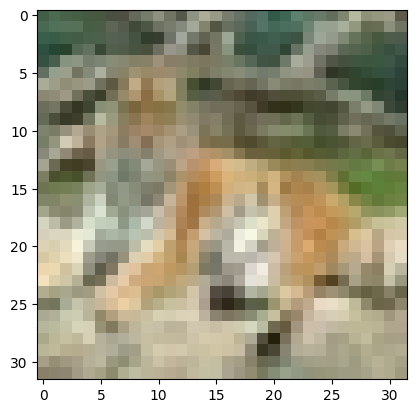

In [87]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



# Display the image
plt.imshow(images[2])



In [88]:
image_captions[2]

'A tiger with a sense of pride in its posture.'

In [89]:
image_classes[2]

88

In [90]:
import numpy as np

# Assuming you have lists images, image_captions, and image_classes containing your data

# Create an array of indices from 0 to the length of your data
indices = np.arange(len(images))

# Randomly select 20,000 indices for testing without replacement
testing_indices = np.random.choice(indices, size=2000, replace=False)

# Use the remaining indices for training
training_indices = np.setdiff1d(indices, testing_indices)

# Use the selected indices to create the testing and training datasets
testing_cnn_data_selected = [images[i] for i in testing_indices]
training_cnn_data_selected = [images[i] for i in training_indices]

testing_lstm_data_selected = [image_captions[i] for i in testing_indices]
training_lstm_data_selected = [image_captions[i] for i in training_indices]

# Create labels (y) for testing and training datasets
testing_labels = [image_classes[i] for i in testing_indices]
training_labels = [image_classes[i] for i in training_indices]

# Now testing_data_selected contains 20,000 randomly selected items for testing
# and training_data_selected contains the remaining items for training
# testing_labels and training_labels contain corresponding labels for testing and training datasets


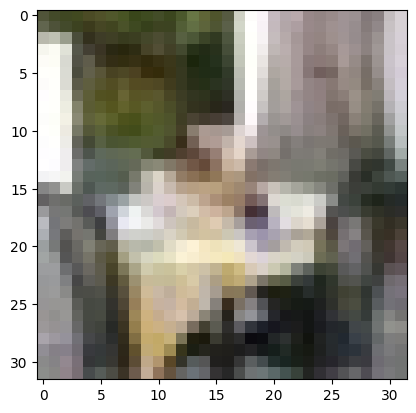

In [91]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



# Display the image
plt.imshow(training_cnn_data_selected[1])



In [92]:
import numpy as np

# Sample testing_labels array
training_labels = np.array(training_labels)

# Define a mapping dictionary to map original labels to new labels (0 to 20)
label_mapping = {}
new_label = 0
for label in sorted(np.unique(training_labels)):
    label_mapping[label] = new_label
    new_label += 1

# Convert the testing_labels array using the mapping dictionary
converted_labels_training = np.array([label_mapping[label] for label in training_labels])

# Print the converted labels
print(converted_labels_training)


[15 15 16 ... 18  1  8]


In [93]:
import numpy as np

# Sample testing_labels array
testing_labels = np.array(testing_labels)

# Define a mapping dictionary to map original labels to new labels (0 to 20)
label_mapping = {}
new_label = 0
for label in sorted(np.unique(testing_labels)):
    label_mapping[label] = new_label
    new_label += 1

# Convert the testing_labels array using the mapping dictionary
converted_labels_testing = np.array([label_mapping[label] for label in testing_labels])

# Print the converted labels
print(converted_labels_testing)


[15 18 12 ...  9 13  2]


In [94]:
testing_labels[0:10]

array([84, 91, 65, 92, 61, 13, 92,  2, 36,  5])

In [95]:
converted_labels_testing[0:10]

array([15, 18, 12, 19, 11,  5, 19,  1,  9,  2])

In [96]:
testing_labels.shape

(2000,)

In [97]:
converted_labels_training[0:10]

array([15, 15, 16,  5, 11, 18, 13, 15, 19,  8])

In [98]:
training_lstm_data_selected[1]

'A table with a typewriter and papers.'

## CNN 

In [99]:
# Convert labels to one-hot encoding
training_labels=np.array(training_labels)
testing_labels=np.array(testing_labels)
training_labels = tf.keras.utils.to_categorical(converted_labels_training, 20)
testing_labels = tf.keras.utils.to_categorical(converted_labels_testing, 20)

In [100]:
training_cnn_data_selected=np.array(training_cnn_data_selected)

In [101]:
testing_cnn_data_selected=np.array(testing_cnn_data_selected)

In [102]:
training_cnn_data_selected.shape

(9984, 32, 32, 3)

In [103]:
training_cnn_data_selected.shape

(9984, 32, 32, 3)

In [105]:
tf.config.experimental_run_functions_eagerly(False)

In [106]:
cnn_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = cnn_model.fit(training_cnn_data_selected,
                            training_labels,
                            batch_size=32,
                            epochs=30,
                            validation_data=(testing_cnn_data_selected,testing_labels),
                            shuffle=True)

Epoch 1/30


2024-04-17 10:46:21.232911: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_139/dropout_156/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


312/312 [==============================] - 5s 8ms/step - loss: 1.3519 - accuracy: 0.6682 - val_loss: 1.0733 - val_accuracy: 0.7020
Epoch 2/30
312/312 [==============================] - 2s 7ms/step - loss: 1.0076 - accuracy: 0.7511 - val_loss: 0.9942 - val_accuracy: 0.7480
Epoch 3/30
312/312 [==============================] - 2s 7ms/step - loss: 0.9022 - accuracy: 0.7808 - val_loss: 0.9258 - val_accuracy: 0.7825
Epoch 4/30
312/312 [==============================] - 2s 7ms/step - loss: 0.8252 - accuracy: 0.7995 - val_loss: 0.9466 - val_accuracy: 0.7840
Epoch 5/30
312/312 [==============================] - 2s 7ms/step - loss: 0.7826 - accuracy: 0.8136 - val_loss: 0.9358 - val_accuracy: 0.7810
Epoch 6/30
312/312 [==============================] - 2s 7ms/step - loss: 0.7266 - accuracy: 0.8274 - val_loss: 0.9365 - val_accuracy: 0.7865
Epoch 7/30
312/312 [==============================] - 2s 7ms/step - loss: 0.7185 - accuracy: 0.8303 - val_loss: 1.0177 - val_accuracy: 0.7630
Epoch 8/30
312/31

In [107]:
testing_labels = np.argmax(testing_labels, axis=1)
training_labels = np.argmax(training_labels, axis=1)

In [108]:
cnn_predictions = cnn_model.predict(testing_cnn_data_selected)

63/63 [==============================] - 0s 2ms/step


In [109]:
predicted_labels = np.argmax(cnn_predictions, axis=1)

# Calculate accuracy
cnn_accuracy = np.mean(predicted_labels == testing_labels)
print("CNN Model Accuracy:", cnn_accuracy)

CNN Model Accuracy: 0.689


In [110]:
df = pd.DataFrame({'caption': training_lstm_data_selected, 'class': training_labels})

In [111]:
df[20:30]

,caption,class
20,"Passengers settle into their seats, preparing ...",17
21,Wispy clouds float gently overhead.,7
22,A group of cows gathers around the watering h...,6
23,A bunch of flowers in a vase with water.,19
24,A close up of a table with a bowl of fruit.,15
25,An image showing a cozy cot nestled next to a ...,2
26,White flowers with a bee collecting nectar.,19
27,A ceramic plate with an abstract design displa...,11
28,A cow with a gentle demeanor approaches the w...,6
29,Fish swimming in a river with rocks.,18


In [112]:

import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from gensim.models import Word2Vec

def tokenize_text(text_data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text_data)
    return tokenizer

def train_word2vec(text_data, embedding_dim):
    tokenized_text = [text.split() for text in text_data]
    model = Word2Vec(sentences=tokenized_text, vector_size=embedding_dim, window=5, min_count=1, workers=4)
    return model

def convert_text_to_vectors(text_data, word2vec_model, max_length):
    vectors = []
    for text in text_data:
        words = text.split()
        vec = []
        for word in words:
            if word in word2vec_model.wv:
                vec.append(word2vec_model.wv[word])
            else:
                vec.append(np.zeros(word2vec_model.vector_size))  # Zero vector for out-of-vocabulary words
        vectors.append(vec)
    padded_vectors = pad_sequences(vectors, maxlen=max_length, padding='post')
    return padded_vectors

In [113]:
df['caption'][147]

'A sleepy cat dozes off in a warm lap.'

In [114]:
max_words=10000
embedding_dim=10

tokenizer = tokenize_text(df['caption'].values)
word2vec_model = train_word2vec(df['caption'].values, embedding_dim)

max_length = max(len(text.split()) for text in df['caption'].values)

#x_vec = convert_text_to_vectors(df['caption'].values, word2vec_model, max_length)
#class_mapping = {f'class_{i}': i for i in range(num_classes)}
#df['class'] = df['class']

#y = df['class'].values

In [115]:
x_vec_train = convert_text_to_vectors(training_lstm_data_selected, word2vec_model, max_length)

In [116]:
x_vec_test = convert_text_to_vectors(testing_lstm_data_selected, word2vec_model, max_length)

In [117]:
training_lstm_data_selected[2]

'A tiger with a sense of pride in its posture.'

In [118]:
training_lstm_data_selected[0:2]

['A wooden table with a fruit bowl in the center.',
 'A table with a typewriter and papers.']

In [119]:
x_vec_train=np.array(x_vec_train)

In [120]:
x_vec_test=np.array(x_vec_test)

In [121]:
training_labels=np.array(training_labels)
testing_labels=np.array(testing_labels)

In [122]:
lstm_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [123]:
x_vec_train.shape

(9984, 24, 10)

In [124]:
training_labels.shape

(9984,)

In [125]:
x_vec_test.shape

(2000, 24, 10)

In [126]:
training_labels = tf.keras.utils.to_categorical(converted_labels_training, 20)
testing_labels = tf.keras.utils.to_categorical(converted_labels_testing, 20)

tf.config.experimental_run_functions_eagerly(True)

In [127]:
history = lstm_model.fit(x_vec_train,
                                training_labels,
                                batch_size=32,
                                epochs=30,
                                validation_data=(x_vec_test,testing_labels),
                                shuffle=True)

Epoch 1/30
312/312 [==============================] - 4s 7ms/step - loss: 2.6785 - accuracy: 0.2334 - val_loss: 1.7004 - val_accuracy: 0.4445
Epoch 2/30
312/312 [==============================] - 2s 6ms/step - loss: 1.7313 - accuracy: 0.4498 - val_loss: 1.3763 - val_accuracy: 0.5755
Epoch 3/30
312/312 [==============================] - 2s 6ms/step - loss: 1.4125 - accuracy: 0.5674 - val_loss: 1.1658 - val_accuracy: 0.6365
Epoch 4/30
312/312 [==============================] - 2s 7ms/step - loss: 1.2551 - accuracy: 0.6252 - val_loss: 0.9677 - val_accuracy: 0.7025
Epoch 5/30
312/312 [==============================] - 2s 6ms/step - loss: 1.1123 - accuracy: 0.6598 - val_loss: 0.8889 - val_accuracy: 0.7250
Epoch 6/30
312/312 [==============================] - 2s 6ms/step - loss: 1.0146 - accuracy: 0.6947 - val_loss: 0.8136 - val_accuracy: 0.7465
Epoch 7/30
312/312 [==============================] - 2s 6ms/step - loss: 0.9189 - accuracy: 0.7215 - val_loss: 0.7942 - val_accuracy: 0.7430
Epoch 

In [128]:
x_vec_test.shape

(2000, 24, 10)

In [129]:
lstm_predictions = lstm_model.predict(x_vec_test)

63/63 [==============================] - 0s 3ms/step


In [142]:
predicted_labels = np.argmax(lstm_predictions, axis=1)

# Calculate accuracy
lstm_accuracy = np.mean(predicted_labels == testing_labels)
print("LSTM Model Accuracy:", lstm_accuracy)

LSTM Model Accuracy: 0.886


In [131]:
predicted_labels

array([15, 18, 12, ...,  9, 13,  2])

In [132]:
testing_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [133]:
len(cnn_predictions)


2000

In [134]:
len(lstm_predictions)

2000

In [135]:
lstm_predictions[0]

array([9.83072005e-06, 1.38123016e-06, 1.44096948e-05, 1.91554045e-06,
       1.13989856e-07, 1.08048084e-06, 6.07343509e-07, 5.79055470e-09,
       8.60960154e-06, 1.97093386e-09, 5.94858779e-03, 5.79317420e-05,
       1.85883528e-05, 2.08153469e-05, 1.24518760e-06, 9.93853927e-01,
       4.80617359e-07, 4.40618624e-06, 8.83937048e-08, 5.57691819e-05],
      dtype=float32)

## LSTM is working and acc is 86.6% (Cifar 10) - VitGpt2 model
## LSTM is working and acc is 93.6% (Cifar 100 - 20 random classes) - Manually generated captions

In [136]:
cnn_predictions[0]

array([1.5605792e-07, 6.1407650e-07, 2.8094586e-03, 7.5734725e-09,
       3.6179326e-06, 1.0954192e-07, 1.2119324e-05, 9.5738395e-09,
       5.5669389e-06, 3.3082672e-11, 3.3077107e-08, 1.5863124e-08,
       1.5333503e-09, 1.4261224e-08, 9.1088532e-09, 9.9716777e-01,
       1.3310893e-07, 1.1027579e-08, 3.5578270e-07, 5.0337579e-08],
      dtype=float32)

In [137]:
cnn_predictions.shape

(2000, 20)

In [138]:
lstm_predictions.shape

(2000, 20)

In [140]:
testing_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [141]:
# Step 5: Late Fusion Ensemble
testing_labels = np.argmax(testing_labels, axis=1)

ensemble_predictions = np.argmax(np.sum([cnn_predictions, lstm_predictions], axis=0), axis=1)

# Step 6: Compare Predictions with Original Classes
accuracy = np.mean(ensemble_predictions == testing_labels)
print("Ensemble Model Accuracy:", accuracy)


Ensemble Model Accuracy: 0.902


## AUTOMATE ENSEMBLE

In [ ]:
import os
import tensorflow as tf

# Define the folder path
folder_path = '/kaggle/input/cnn-models/cnn'

# Get a list of all files in the folder
file_list = os.listdir(folder_path)

# Filter out only the .h5 files
model_files = [file for file in file_list if file.endswith('.h5')]

# Load each model
cnn_models = []
for model_file in model_files[0:4]:
    model_path = os.path.join(folder_path, model_file)
    cnn_model = tf.keras.models.load_model(model_path)
    cnn_models.append(cnn_model)

# Now cnn_models list contains all the loaded CNN models


In [ ]:
# Train each model and track validation accuracy
validation_accuracies = []
for lstm_model in top_lstm_models:
    history = lstm_model.fit(x_vec_train,
                             training_labels,
                             batch_size=32,
                             epochs=1,
                             validation_data=(x_vec_test, testing_labels),
                             shuffle=True)
    
    # Get the validation accuracy from the history
    validation_accuracy = history.history['val_accuracy'][-1]
    validation_accuracies.append(validation_accuracy)

# Sort the models based on validation accuracy
sorted_indices = sorted(range(len(validation_accuracies)), key=lambda i: validation_accuracies[i], reverse=True)
top_lstm_models = [lstm_models[i] for i in sorted_indices[:4]]  # Select the top 4 models

# Train the top 4 LSTM models
histories = []
for lstm_model in top_lstm_models:
    lstm_model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = lstm_model.fit(x_vec_train,
                             training_labels,
                             batch_size=32,
                             epochs=1,
                             validation_data=(x_vec_test, testing_labels),
                             shuffle=True)
    histories.append(history)


# Load the LSTM and CNN models
lstm_model = tf.keras.models.load_model('/kaggle/input/lstm-parent-model-final/parent_0_model (1).h5')
cnn_model = tf.keras.models.load_model('/kaggle/input/cnn-model-16layers/cnn_model_.h5')

In [ ]:
from collections import Counter
# Assuming you have lists of predictions from the top LSTM and CNN models
cnn_predictions = [model.predict(testing_cnn_data_selected) for model in cnn_models]
lstm_predictions = [model.predict(x_vec_test) for model in top_lstm_models]

# Combine predictions using majority voting



In [ ]:
from sklearn.metrics import accuracy_score

# Combine predictions using majority voting
def majority_voting(predictions):
    combined_predictions = []
    for sample_predictions in zip(*predictions):
        sample_predictions_list = [tuple(prediction) for prediction in sample_predictions]
        votes = Counter(sample_predictions_list)
        majority_vote = votes.most_common(1)[0][0]
        combined_predictions.append(majority_vote)
    return combined_predictions




# Combine LSTM and CNN predictions using majority voting
ensemble_predictions = majority_voting(lstm_predictions + cnn_predictions)
ensemble_classes = [prediction.index(max(prediction)) for prediction in ensemble_predictions]


predicted_labels = np.argmax(lstm_predictions, axis=1)

# Calculate accuracy
#lstm_accuracy = np.mean(ensemble_predictions == testing_labels)
#print("Ensemble Accuracy:", lstm_accuracy)


# Evaluate ensemble performance
ensemble_accuracy = accuracy_score(testing_labels, ensemble_classes)

In [ ]:
np.shape(lstm_predictions)


In [ ]:
np.shape(cnn_predictions)

In [ ]:
lstm_predictions

In [ ]:
import numpy as np

# Convert lists to NumPy arrays
lstm_predictions_array = np.array(lstm_predictions)
cnn_predictions_array = np.array(cnn_predictions)

# Reshape LSTM and CNN predictions to (num_samples, sequence_length * num_classes)
lstm_predictions_reshaped = lstm_predictions_array.reshape(lstm_predictions_array.shape[0], -1)
cnn_predictions_reshaped = cnn_predictions_array.reshape(cnn_predictions_array.shape[0], -1)

# Concatenate reshaped predictions
x_train = np.concatenate((lstm_predictions_reshaped, cnn_predictions_reshaped), axis=1)

# Assuming y_train contains ground truth labels with shape (num_samples,)


In [ ]:
lstm_predictions[0][0]

In [ ]:
lstm_pred = 

In [ ]:
import numpy as np
import tensorflow as tf

# Prepare Data
# Assuming lstm_predictions, cnn_predictions, and correct_outputs contain the predictions and correct outputs
# Concatenate LSTM and CNN predictions
x_train = np.concatenate((lstm_predictions[0], cnn_predictions[0]), axis=1)

# Calculate Weightage Distribution
# For example, calculate the weightage based on accuracy
lstm_accuracy = accuracy_score(lstm_predictions[0], testing_labels)
cnn_accuracy = accuracy_score(cnn_predictions[0], testing_labels)
total_accuracy = lstm_accuracy + cnn_accuracy
lstm_weight = lstm_accuracy / total_accuracy
cnn_weight = cnn_accuracy / total_accuracy

# Prepare Target Weightage Distribution
target_weightage = np.concatenate((lstm_weight, cnn_weight), axis=1)

# Define Fusion Network Architecture
fusion_network = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(num_features,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(num_modalities, activation='softmax')  # Output layer for weightage distribution
])

# Compile Fusion Network
fusion_network.compile(optimizer='adam', loss='categorical_crossentropy')

# Train Fusion Network
fusion_network.fit(x_train, target_weightage, epochs=10, batch_size=32, validation_split=0.2)


In [ ]:
ensemble_classes = [prediction.index(max(prediction)) for prediction in ensemble_predictions]


In [ ]:
ensemble_classes[0]

In [ ]:
# CIFAR-10 class names
cifar_10_classes = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

# Printing class names for the first 10 elements in image_classes
print("Class Names:")
for class_index in image_classes[:10]:
    print(cifar_10_classes[class_index])


In [ ]:
image_captions[0:10]

In [ ]:
image_classes[0:10]


In [ ]:

# Define the ensemble function
def ensemble(lstm_outputs, cnn_outputs):
    # Add your ensemble code here
    return lstm_outputs, cnn_outputs

# Make predictions on the image and text data
lstm_predictions = []
cnn_predictions = []
for image_batch, text_batch in zip(image_generator, text_generator):
    lstm_outputs = lstm_model.predict(text_batch)
    cnn_outputs = cnn_model.predict(image_batch)
    lstm_predictions.append(lstm_outputs)
    cnn_predictions.append(cnn_outputs)
lstm_predictions = np.vstack(lstm_predictions)
cnn_predictions = np.vstack(cnn_predictions)

# Ensemble the predictions using voting strategy
ensemble_predictions = ensemble(lstm_predictions, cnn_predictions)

# Take the average of the probabilities from both models for each class
ensemble_predictions = (ensemble_predictions[0] + ensemble_predictions[1]) / 2

# Select the class with the highest average probability as the final prediction
final_predictions = np.argmax(ensemble_predictions, axis=1)